# Training Deep Neural Networks

# A. The Vanishing/Exploding Gradients Problems:
* Generally, DNNs suffer from unstable gradients; different layers may learn at widely different speeds.
    * One of the few suspects is the combination of the sigmoid activation function and the weight initialization technique (normal distribution w/ mean=0, and std=1).  The variance of the outputs of each layer is much greater than the variance of its inputs. The variance keeps increasing after each layer until the activation function saturates at the top layers. When backpropagation kicks in it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

* **Vanishing Gradients** Problem:
    * The backpropagation algorithm's 2nd phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function w/ regard to each parameter in the network, it uses these gradients to update each parameter w/ a gradient descent step.
    * Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers' connection weights virtually unchanged, and trainign never converges to a good solution.

* **Exploding Gradients** Problem:
    * The gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges.
    * Surfaces most often in recurrent neural networks.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

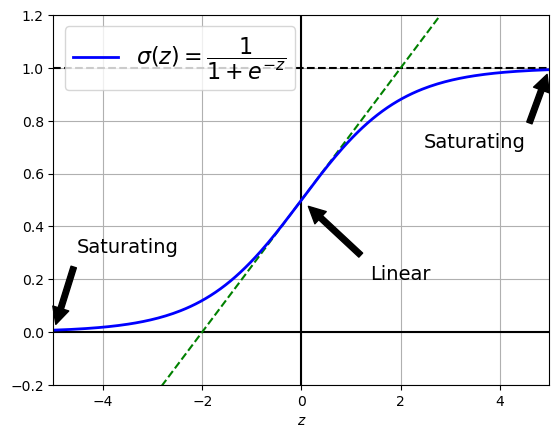

In [2]:
# Sigmoid Activation Function saturation:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16);

### A.1. Glorot and He Initialization:

* To alleviate the unstable gradients problem, the signal needs to flow properly in both directions: In the forward direction when making predictions, and in the reverse direction when backpropagating gradients.
    * The signal should not die out, nor explode and saturate. For the signal to flow properly:
        * The variance of the outputs of each layer should be equal to the variance of the inputs.
        * The gradients needs to have equal variance before and after flowing through a layer in the reverse direction.
    * It is actually not possible to guarantee both unless the layer has an equal number of inputs and outputs (*fan-in* and *fan-out* of the layer), but *Glorot* and *Bengio* proposed a good compromise:
        * The connection weights of each layer must be initialized randomly, **Glorot Initialization or Xaviar Initialization**: <br>
        &emsp; *when using the sigmoid activation function* <br>
        &emsp; Normal distribution w/ mean, $\mu$=0 and variance ,$\sigma^2=\frac{1}{fan_{avg}}$ <br>
        &emsp; Uniform distribution between $-r$ and $+r$, w/ $r\ =\ \sqrt{\frac{3}{fan_{avg}}}$ <br>
        &emsp; where $fan_{avg}\ =\ \frac{fan_{in}\ +\ fan_{out}}{2}$
        * Using Glorot Initialization can speed up training considerably.

    * **LeCun Initialization**:
        * Is equivalent to Glorot initialization when $fan_{in}\ =\ fan_{out}$

* Initialization parameters for each type of activation function: <br><br>
    &emsp; 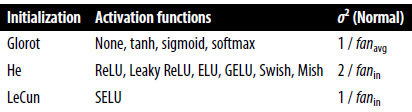

* By default, `Keras` uses Glorot initialization w/ a uniform distribution.
    * When creating a layer, you can switch to *He Initialization* by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`.
    * Alternatively, other initialization techniques can be obtained using the `VarianceScaling` initializer.

In [3]:
dense = tf.keras.layers.Dense(
    50,
    activation="relu",
    kernel_initializer="he_normal"
)

In [4]:
# Using the VarianceScaling class : Creating He Initialization w/ uniform distribution and based on fan_avg
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2,
    mode="fan_avg", 
    distribution="uniform"
)

dense = tf.keras.layers.Dense(
    50,
    activation="sigmoid",
    kernel_initializer=he_avg_init
)

### A.2. Better Activation Functions:

* Poor choice of activation functions leads to unstable gradients.
* Other activation functions behave much better in deep neural networks, in particular the ReLU activation fuction, mostly because it does not saturate for positive values, and also because it is very fast to compute. Unfortunately, the ReLU suffers from a problem known as the *dying ReLUs*:
    * During training, some neurons effectively die. They stop outputting anything other than 0. In some cases, half of the network's neurons are dead, especially if you used a large learning rate.
    * A neuron dies when its weights get tweaked in such a way that the input of the ReLU is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.
        * A dead neuron may come back to life if its inputs evolve over time and eventually return w/in a range where the ReLU activation function gets a positive input again. For example, this may happen if gradient descent tweaks the neurons in the layers below the dead neuron.
    * Using a variant of the ReLU function, such as leaky ReLU, can solve this problem.

##### Leaky ReLU

* $LeakyReLU_{\alpha}(z)\ =\ max(\alpha z, z)$ : <br>
    * $\alpha$ = This hyperparameter defines how much the function leaks: it is the slope of the function for $z < 0$.
        * Having a slope for $z < 0$ ensures that leaky ReLUs never die.
    * Leaky Variants always outperformed the strict ReLU activation function.
        * Setting $\alpha\ =\ 0.2$ (large leak) seemed to result in better performance than $\alpha\ =\ 0.01$ (small leak).
    * Randmized Leaky ReLU (RReLU):
        * $\alpha$ is picked randomly in a given range during training and is fixed to an average during test.
        * Act as a regularizer, reducing the risk of overfitting the training set.
    * Parametric Leaky ReLU (PReLU):
        * $\alpha$ is authorized to be learned during training: instead of being a hyperparameter. It becomes a parameter that can be modified by backpropagation like any other parameter.
        * Strongly outperform ReLU on large image datasets, but on small dataset it runs the risk of overfitting the training set.

* ReLU, Leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions:
    * Their derivatives abruptly change (at z = 0).
    * This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence.

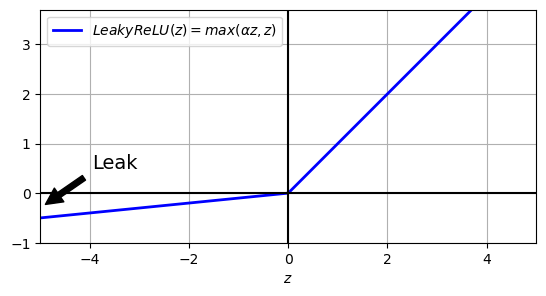

In [5]:
# Leaky ReLU 
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend();

In [6]:
# implementing leaky rely in keras
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(
    50,
    activation=leaky_relu,
    kernel_initializer="he_normal"
)

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

In [8]:
# implementing PRelu in keras
parametric_relu = tf.keras.layers.PReLU()
dense = tf.keras.layers.Dense(
    50,
    activation=parametric_relu,
    kernel_initializer="he_normal"
)

In [9]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.PReLU(),  # activation as a separate layer
    # [...]  # more layers
])

##### Exponential Linear Unit (ELU) and Scaled Exponential Linear Unit (SELU):

* Exponential Linear Unit (ELU):
    * ELU Activation Function: <br>
    &emsp; $ELU_{\alpha}(z)\ =\begin{dcases} \mathrm{\alpha(exp(z)-1)\ if\ z\ <\ 0} \\ \mathrm{z\ if\ z\ \geq\ 0} \\  \end{dcases}$ <br>
    * ELU takes on negative values when z<0, w/c allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem.
        * The hyperparameter $\alpha$ defines the opposite of the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.
    * ELU has a nonzero gradient for z<0, w/c avoids the dead neurons problem.
    * If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z=0$, w/c helps speed up gradient descent since it does not bounce as much to the left and right of $z=0$.
    * `activation="elu"`, w/ `HE initialization`
    * Main drawback of ELU is that it is slower to compute than the ReLU function and its variants, due to the use of the exponential function. Its faster convergence rate during training may compensate for the slow computation, but still, at test time an ELU network will be a bit slower than a ReLU network.

* Scaled ELU (SELU):
    * Scaled variant of the ELU activation function (about 1.05 times ELU, using $\alpha\ \approx\ 1.67$).
    * `activation="selu"`.
    * If you build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will self-normalize: <br>
        * The output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem.
    * For the self-normalization to happen:
        * The input features must be standardized: mean 0 and standard deviation 1.
        * Every hidden layer’s weights must be initialized using LeCun normal initialization. `kernel_initializer="lecun_normal"`
        * The self-normalizing property is only guaranteed with plain MLPs.
        * You cannot use regularization techniques like ℓ1 or ℓ2 regularization, max-norm, batch-norm, or regular dropout.

In [10]:
dense = tf.keras.layers.Dense(
    50,
    activation="elu",
    kernel_initializer="he_normal"
)

In [11]:
dense = tf.keras.layers.Dense(
    50,
    activation="selu",
    kernel_initializer="lecun_normal"
)

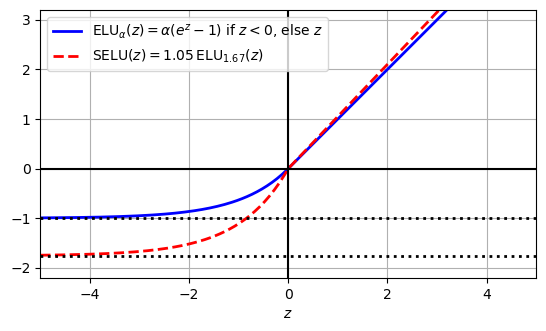

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend();

##### GELU, Swish, and Mish:

* **GELU (Gaussian Error Linear Units)**:
    * Smooth variant of the ReLU activation function.
    * GELU activation function: $GELU(z)\ =\ z\Phi(z)$, where:
        * $\Phi$ is the standard Guassian cumulative distribution function (CDF)
        * $\Phi(z)$ corresponds to the probability that a value sampled randomly from a normal distriution of mean=0 and variance=1 is lower than z.
        * GELU approaches 0 when its input z is very negative,and it approaches z when z is very positive.
        * GELU has a curvature at every point w/c makes it works so well, especially for complex tasks: Gradient descent may find it easier to fit complex patterns. However it is more computationlly intensive and the performance boost it provides is not always sufficient to justify the extra cost.
    * `activation="gelu"`.

* **Swish**:
    * Sigmoid Linear Unit (SiLU) activation function : $z\sigma(z)$.
        * `activation="swish"`
    * Generalized Swish : $Swish_\beta(z)\ =\ z\sigma(\beta z) $.
        * GELU is approximately equal to the generalized Swish function using $\beta$ = 1.702.
        * $\beta$ can be tuned like any hyperparameter. Alternatively, it's also possible to make $\beta$ trainable and let gradient descent optimize it, but it runs the risk of overfitting the data.

* **Mish**:
    * $Mish(z)\ =\ z\ tanh(softplus(z))$ where:
        * $softplus(z)\ =\ log(1\ +\ exp(z))$.
    * Smooth, nonconvex, and nonmonotonic variant of ReLU.
    * Mish overlaps almost perfectly w/ Swish when z is negative, and almost perfectly w/ GELU when z is positive.

* W/c activation function should you use for the hidden layers of your deep neural network?
    * ReLU remains a good defualt for a simple taks: it’s often just as good as the more sophisticated activation functions, plus it’s very fast to compute, and many libraries and hardware accelerators provide ReLU-specific optimizations.
    * However, Swish is probably a better default for more complex tasks, and you can even try parametrized Swish with a learnable β parameter for the most complex tasks.
    * Mish may give you slightly better results, but it requires a bit more compute. 
    * If you care a lot about runtime latency, then you may prefer leaky ReLU, or parametrized leaky ReLU for more complex tasks.
    * For deep MLPs, give SELU a try.
    * If you have spare time and computing power, you can use cross-validation to evaluate other activation functions as well.

* Other keras activations:
    * `tf.keras.activations...`
    * [Online Docs](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

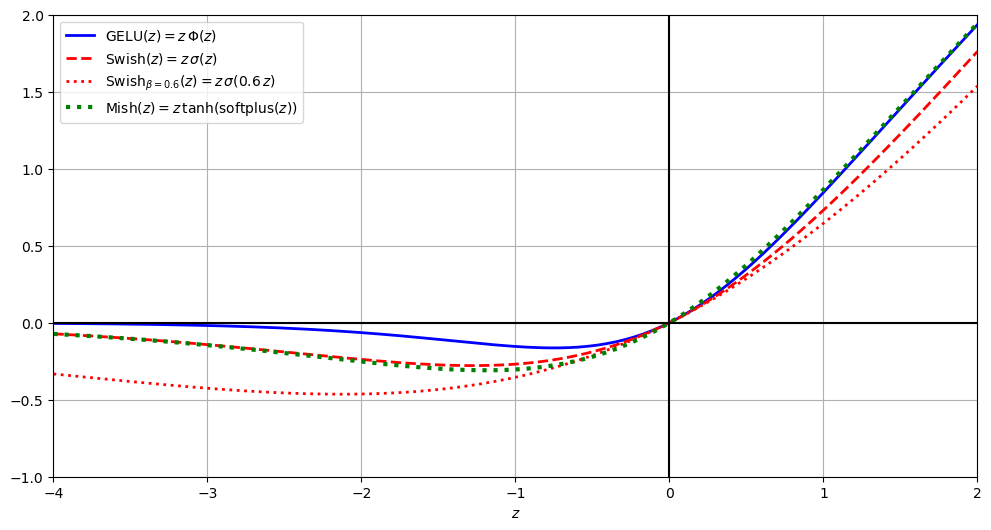

In [13]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6

plt.figure(figsize=(12, 6))
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left");

### A.3. Batch Normalization:

* Using He initialization along with ReLU (or any of its variants) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

* **Batch Normalization (BN)**:
    * This technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation zero-centers and normalizes each input, then scales and shifts the result using 2 new parameter vectors per layer: one for scaling, the other for shifting.
    * This operation lets the model learn the optimal scale and mean of each of the layer's inputs.
    * In many cases standardizing the training set is not needed when adding a BN layer as the 1st layer of a neural network.
    * In order to zero-center and normalize the inputs, the algorithm needs to estimate each input's mean and standard deviation. It does so by evaluating the mean and std of the input over the current mini-batch.

* **BN Algorithm**:
    1. $\mu_B\ =\large\ \frac{1}{m_B}\ \sum_{i=1}^{m_B}\ (x^{(i)})$:
        * $\mu_B$ = vector of input means, evaluated over the whole mini-batch, B. It contains one mean per input.
        * $m_B$ = number of instances in the mini-batch.
    2.  $\sigma_B^2\ =\large\ \frac{1}{m_B}\ \sum_{i=1}^{m_B}\ (x^{(i)}-\mu_B)^2$:
        * $\sigma_B$ = vector input standard deviations, evaluated over the whole mini-batch. It contains one std per input.
    3. $\hat{x}^{(i)}\ =\Large\  \frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2\ +\ \varepsilon}}$:
        * $\hat{x}^{(i)}$ = vector of zero-centered and normalized inputs for instance i.
        * $\varepsilon$ = tiny number that avoids division by zero and ensures the gradients don't grow too large ( typically $10^{-5}$ ). This is called a *smoothing term*.
    4. $z^{(i)}\ =\ \gamma \bigotimes\ \hat{x}^{(i)}\ +\ \beta$:
        * $z^{(i)}$ = output of the BN operation. It is a rescaled and shifted version of the inputs.
        * $\gamma$ = output scale parameter vector for the layer. It contains one scale parameter per input.
        * $\bigotimes$ = element-wise multiplication. Each input is multiplied by its corresponding output scale parameter.
        * $\beta$ = output shift (offset) parameter for the layer. It contains one offset parameter per input. Each input is offset by its corresponding shift parameter.

* During  training, BN standardizes its inputs, then rescales and offsets them. But for test time,we may need to make predictions for individual instances rather than for batch instances, in this case we will have no way to compute each input's mean and standard deviation. Computing statistics over the batch instances would be unreliable. 
    * One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of batch normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations (ex. Keras' `BatchNormalization` layer.)
    * 4 parameter vectors are learned in each batch-normalized layer:
        * $\gamma$ = output scale vector learned through regular backpropagation
        * $\beta$ = output offset vector learned through regular backpropagation
        * $\mu$ = final input mean vector estimated using an exponential moving average.
        * $\sigma$ = final input std vector estimated using an exponential moving average.
    * $\mu$ and $\sigma$ are estimated during training, but they are used only after training to replace the batch input means and standard deviations.

* Batch normalization acts like a regulizer, reducing the need for other regularization techniques. Batch normalization does, however, add some complexity to the model. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer.

* You may find that training is rather slow, because each epoch takes much more time when you use batch normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, wall time will usually be shorter.

##### Implementing batch normalization with Keras:

* Add `BatchNormalization` layer before or after each hidden layer's activation function - as w/c is preferable depends on the task.
    * To add the BN layers before the activation function, you must remove the activation functions from the hidden layers and add them as separate layers after the BN layers.
    * Since a batch normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer by passing `use_bias=False` when creating it.
    * Lastly, you can usually drop the first BN layer to avoid sandwiching the first hidden layer between two BN layers.
    
* You may also add a BN layer as the first layer in your model, but a plain `Normalization` layer generally performs just as well in this location (its only drawback is that you must first call its `adapt()` method).

* `BatchNormalization` important hyperparameters:
    * `momentum`:
        * hyperparameter used by the BN layer when it updates the EMA. 
        * Given a new value, **v**, the layer updates the running $\hat{v}$ using the equation: <br>
        &emsp; $\hat{v} \leftarrow\ \hat{v}\ x momentum\ + v\ x\ (1-momentum)$
        * A good momentum value is typically close to 1 (0.9, 0.99, 0.9999). You want more 9s for larger datasets and for smaller mini-batches.
    * `axis`:
        * It determines w/c axis should be normalized.
        * Default is -1. It will normalize the last axis (using the means and std computed across the other axes.)
        * When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch.

* Batch normalization has become one of the most-used layers in deep neural networks, especially deep convolutional neural networks to the point that it is often omitted in the architecture diagrams: it is assumed that BN is added after every layer.

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [15]:
# Adding bn after each dense layer
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [17]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [18]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [19]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd",
              metrics="accuracy"
)

model.fit(
    X_train, y_train, 
    epochs=2, 
    validation_data=(X_valid, y_valid)
)

Epoch 1/2
  96/1719 [>.............................] - ETA: 10s - loss: 1.0952 - accuracy: 0.6279

1719/1719 [==============================] - 17s 9ms/step - loss: 0.5477 - accuracy: 0.8087 - val_loss: 0.3969 - val_accuracy: 0.8522
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4050 - accuracy: 0.8545 - val_loss: 0.3629 - val_accuracy: 0.8664


In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [21]:
# Adding the batch normalization layer before each dense layer
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),

    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, 
          epochs=2, 
          validation_data=(X_valid, y_valid))

Epoch 1/2


1719/1719 [==============================] - 14s 7ms/step - loss: 0.6091 - accuracy: 0.7964 - val_loss: 0.4341 - val_accuracy: 0.8434
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4286 - accuracy: 0.8496 - val_loss: 0.3777 - val_accuracy: 0.8634


### A.4. Gradient Clipping:

* Gradient Clipping is another technique used to mitigate the exploding gradients problem. It clips the gradient during backpropagation so that they never exceed some threshold. 
    * Generally used in recurrent neural networks, where using batch normalization is tricky.

* In Keras, gradient clipping is implemented by setting the `clipvalue` or `clipnorm` argument when creating an optimizer.
    * All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments.
    * This optimizer will clip every component of the gradient vector to a value between -1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0.
    * If you want to ensure that gradient clipping does not change the direction of the gradient vector, you should clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its ℓ2 norm is greater than the threshold you picked.
    * If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try clipping by value or clipping by norm, with different thresholds, and see which option performs best on the validation set.

In [22]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer
)

In [23]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer
)

# B. Reusing Pretrained Layers:

* **Transfer Learning**:
    * It is generally not a good idea to train a very large DNN from scratch without first trying to find an existing neural network that accomplishes a similar task to the one you are trying to tackle. If you find such as neural network, then you can generally reuse most of its layers, except for the top ones.
    * This will speed up training and just requires less training data. <br>
    &emsp; 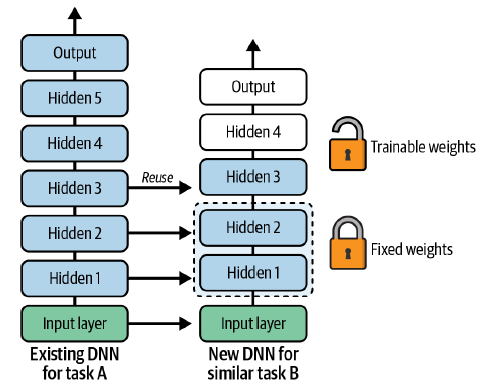
    <br>
    * The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and probably will not have the right number of outputs. Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task.
    * The more similar the tasks are, the more layers you will want to reuse (starting with the lower layers). For very similar tasks, try to keep all the hidden layers and just replace the output layer.

* To find the proper layers to reuse:
    * Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent won’t modify them and they will remain fixed), then train your model and see how it performs.
      * Freezing reused layers during the first few epochs prevents large errors and give the new layers some time to learn reasonable weights.
      * Must compile your model after freezing or unfreezing layers.
    * Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves.
    * The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.
    * If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again
    * If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.
    * Iterate until you find the right number of layers to reuse.

### B.1. Transfer Learning with Keras:
* ```model2 = tf.keras.models.load_model(model1) ``` <br>
  ```model2_a = tf.keras.Sequential(model2.layers) ```:
    * This will create a new model , `model2`, based on `model1`. They both share the same layers.
    * Training `model2_a` will affect `model1`.
    * To prevent this from happening, use `tf.keras.models.clone_model` but this will only clone the architecture not the weights. The weights can be copied by using `set_weights()`, if not the new model will be initialized randomly when the cloned model is first used.

* Transfer learning works best w/ convolutional neural networks, w/c tend to learn feature detectors that are much more general, especially in the lower layers.
  * But, transfer learning does not work very well w/ small dense networks,presumably because small networks learn few patterns, and dense networks learn very specific patterns, w/c a re unlikely to be useful in other tasks.

In [24]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [25]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [26]:
# Model A: Contain 8 classes (except sandal and tshirt)

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

print(f"Pos ID: {pos_class_id} \nNeg ID: {neg_class_id}")

Pos ID: 2 
Neg ID: 0


In [27]:
def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200] # Assume 200 datasets only for Model B
y_train_B = y_train_B[:200] # Assume 200 datasets only for Model B

In [28]:
tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"]
)

history = model_A.fit(
    X_train_A, y_train_A,
    epochs=20,
    validation_data=(X_valid_A, y_valid_A)
)

model_A.save("fmnist_model_A")

Epoch 1/20
  99/1376 [=>............................] - ETA: 4s - loss: 2.0432 - accuracy: 0.2153

1376/1376 [==============================] - 7s 4ms/step - loss: 1.1300 - accuracy: 0.6367 - val_loss: 0.6828 - val_accuracy: 0.7924
Epoch 2/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.5879 - accuracy: 0.8178 - val_loss: 0.5021 - val_accuracy: 0.8378
Epoch 3/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.4721 - accuracy: 0.8529 - val_loss: 0.4290 - val_accuracy: 0.8566
Epoch 4/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.4144 - accuracy: 0.8663 - val_loss: 0.3857 - val_accuracy: 0.8721
Epoch 5/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3785 - accuracy: 0.8768 - val_loss: 0.3586 - val_accuracy: 0.8772
Epoch 6/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3541 - accuracy: 0.8828 - val_loss: 0.3402 - val_accuracy: 0.8814
Epoch 7/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3365 - accuracy: 0.8871 - val_loss: 0.3266 - val_accuracy: 0.8847
Epo

In [29]:
model_A = tf.keras.models.load_model("fmnist_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1]) # reuse all layers except the output layer
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid")) # add an output layer for the new model

In [30]:
tf.random.set_seed(42)

In [31]:
# using clone
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [32]:
Model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [33]:
# Freeze the reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [34]:
history = model_B_on_A.fit(
    X_train_B, y_train_B,
    epochs=4,
    validation_data=(X_valid_B, y_valid_B)
)

#unfreeze the layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(0.0001)
model_B_on_A.compile(
    loss="binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

history = model_B_on_A.fit(
    X_train_B, y_train_B,
    epochs=16,
    validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4


7/7 [==============================] - 2s 115ms/step - loss: 0.7849 - accuracy: 0.4450 - val_loss: 0.7578 - val_accuracy: 0.4847
Epoch 2/4
7/7 [==============================] - 0s 35ms/step - loss: 0.7843 - accuracy: 0.4450 - val_loss: 0.7573 - val_accuracy: 0.4847
Epoch 3/4
7/7 [==============================] - 0s 25ms/step - loss: 0.7837 - accuracy: 0.4450 - val_loss: 0.7568 - val_accuracy: 0.4847
Epoch 4/4
7/7 [==============================] - 0s 24ms/step - loss: 0.7830 - accuracy: 0.4450 - val_loss: 0.7562 - val_accuracy: 0.4847
Epoch 1/16
7/7 [==============================] - 2s 110ms/step - loss: 0.7826 - accuracy: 0.4450 - val_loss: 0.7562 - val_accuracy: 0.4847
Epoch 2/16
7/7 [==============================] - 0s 27ms/step - loss: 0.7825 - accuracy: 0.4450 - val_loss: 0.7561 - val_accuracy: 0.4847
Epoch 3/16
7/7 [==============================] - 0s 24ms/step - loss: 0.7824 - accuracy: 0.4450 - val_loss: 0.7561 - val_accuracy: 0.4847
Epoch 4/16
7/7 [=======================

In [35]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.7453 - accuracy: 0.5000


[0.7452958226203918, 0.5]

### B.2. Unsupervised Pretraining:

* Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task. First, you should try to gather more labeled training data, but if you can’t, you may still be able to perform **Unsupervised Pretraining**.
    * If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network.
    * Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning (i.e., with the labeled training examples).

* Unsupervised pretraining (today typically using autoencoders or GANs rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

* *Greedy Layer-wise pretraining*:
    * Technique used in the early days of deep learning since it was difficult to train deep models.
    * First, train an unsupervised model w/ a single layer, typically an RBM (Restricted Boltzmann Machines).
    * Then would freeze that layer and add another one on top of it, then train the model againn (effectively just training the new layer) then freeze the new layer and add another layer on top of it, train the model again and so on. <br>
    &emsp; 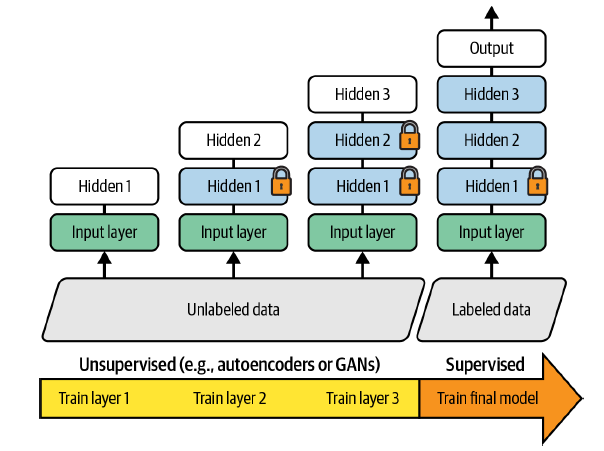
    <br>

* Nowadays, things are much simpler: people generally train the full unsupervised model in one shot and use autoencoders or GANs rather than RBMs.

### B.3. Pretraining on an Auxiliary Task:

* If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

* Self-supervised learning is when you automatically generate the labels from the data itself.

# C. Faster Optimizers:

* Ways to speed up training:
    1. Applying a good initialization strategy for the connection weight.
    2. Using a good activation function.
    3. Using batch normalization.
    4. Reusing parts of a pretrained network.
    5. Using a faster optimzer than the regular gradient descent optimizer.

* Most popular optimization algorithms:
    * Momentum
    * Nesterov Accelerated gradient
    * AdaGrad
    * RMSProp
    * Adam and its variants.

### C.1. Momentum:

* Regular gradient descent will take small steps when the slope is gentle and big steps when the slope is steep, but it will never pick up speed. As a result, regular gradient descent is generally much slower to reach the minimum than momentum optimization.

* Momentum optimization cares a great deal about what previous gradients were: At each iteration, it subtracts the local gradient from the *momentum vector*, **m** (multiplied by the learning rate, $\eta$), and it updates the weights by adding this momentum vector.
    * The gradient is used as an acceleration, not as a speed.
    * To simulate some sort of friction mechanism and prevent the momentum from growing too large ,the algorithm introduces a new hyperparameter $\beta$, called the *momentum*, w/c must be set between 0 (high friction) and 1(no friction). A typical momentum value is 0.9.

* Since momentum optimization ends up going faster than gradient descent, this allows it to escape from plateaus much faster than gradient descent.

* Due to the momentum, the optimizer may overshoot a bit, thencome back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

* Momentum Algorithm:
    1. $m \leftarrow \beta m\ -\ \eta \bigtriangledown_\theta J(\theta)$
    2. $\theta \leftarrow \theta + m$

* One drawback of momentum optimization is that it adds yet another hyperparameter tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular gradient descent.

In [36]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, 
                     epochs=10,
                     validation_data=(X_valid, y_valid))

In [37]:
# Momentum optimzer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [38]:
history_mo = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 13s 7ms/step - loss: 0.6869 - accuracy: 0.7686 - val_loss: 0.5065 - val_accuracy: 0.8182
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4654 - accuracy: 0.8367 - val_loss: 0.4432 - val_accuracy: 0.8388
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4210 - accuracy: 0.8523 - val_loss: 0.4127 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3948 - accuracy: 0.8615 - val_loss: 0.3817 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3744 - accuracy: 0.8681 - val_loss: 0.3735 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3605 - accuracy: 0.8701 - val_loss: 0.3753 - val_accuracy: 0.8640
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3443 - accuracy: 0.8758 - val_loss: 0.3631 - val_accuracy: 0.8648
E

### C.2. Nesterov Accelerated Gradient (NAG):

* Also known as Nesterov Momentum Optimization, measures the gradient of the cost function not the local position $\theta$ but slightly ahead in the direction of the momentum, $\theta + \beta m$.

* NAG Algorithm:
    1. $m \leftarrow \beta m - \eta \bigtriangledown_\theta J(\theta + \beta m)$
    2. $\theta \leftarrow \theta + m$

* This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in the direction rather than the gradient at the original position. <br>
    &emsp; 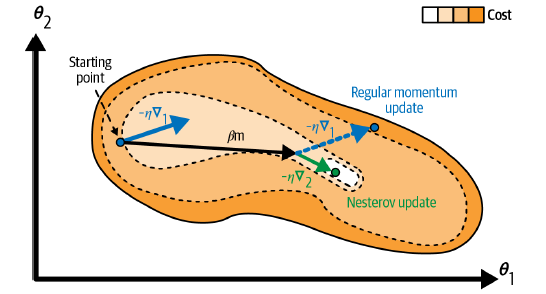 <br>

* To use NAG, set `nesterov=True` when creating the SGD optimizer.

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [40]:
history_nesterove = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 8s 4ms/step - loss: 0.6871 - accuracy: 0.7668 - val_loss: 0.4904 - val_accuracy: 0.8196
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4580 - accuracy: 0.8402 - val_loss: 0.4363 - val_accuracy: 0.8382
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4146 - accuracy: 0.8527 - val_loss: 0.4014 - val_accuracy: 0.8588
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3890 - accuracy: 0.8622 - val_loss: 0.3793 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3689 - accuracy: 0.8686 - val_loss: 0.3720 - val_accuracy: 0.8628
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3552 - accuracy: 0.8737 - val_loss: 0.3824 - val_accuracy: 0.8684
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3407 - accuracy: 0.8782 - val_loss: 0.3772 - val_accuracy: 0.8600
Ep

### C.4. AdaGrad:

* The AdaGrad algorithm point a bit more toward the global optimum. It scales down the gradient vector along the steepest dimensions.

* AdaGrad Algorithm:
    1. $s \leftarrow\ s + \bigtriangledown_\theta J(\theta) \bigotimes \bigtriangledown_\theta J(\theta)$
    2. $\theta \leftarrow \theta - \eta\bigtriangledown_\theta J(\theta) \oslash \sqrt{s + \epsilon}$

* This algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions w/ gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum. This requires much less tuning of the learning rate hyperparameter $\eta$. <br>
    &emsp; 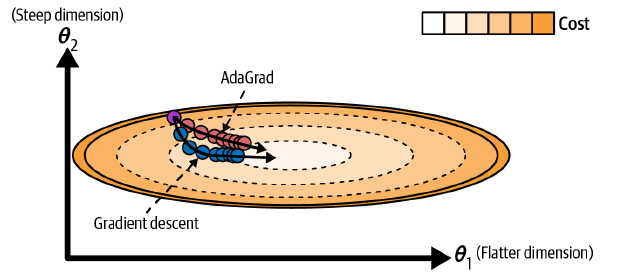 <br>

* AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks: the learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. Thus is should not be used to train dnns.


In [41]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [42]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 9s 5ms/step - loss: 1.0435 - accuracy: 0.6537 - val_loss: 0.6919 - val_accuracy: 0.7684
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6447 - accuracy: 0.7854 - val_loss: 0.5865 - val_accuracy: 0.8002
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5727 - accuracy: 0.8091 - val_loss: 0.5427 - val_accuracy: 0.8146
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5361 - accuracy: 0.8219 - val_loss: 0.5168 - val_accuracy: 0.8236
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5118 - accuracy: 0.8290 - val_loss: 0.4981 - val_accuracy: 0.8254
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4942 - accuracy: 0.8340 - val_loss: 0.4859 - val_accuracy: 0.8290
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4809 - accuracy: 0.8373 - val_loss: 0.4744 - val_accuracy: 0.8312
Ep

### C.5. RMSProp:

* The RMSProp algorithm accumulates only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training. It does so by using exponential decay in the first step.

* RMSProp Algorithm:
    1. $s \leftarrow\ \rho s +(1-\rho) \bigtriangledown_\theta J(\theta) \bigotimes \bigtriangledown_\theta J(\theta)$
    2. $\theta \leftarrow \theta - \eta\bigtriangledown_\theta J(\theta) \oslash \sqrt{s + \epsilon}$

* The decay rate $\rho$ is typically set to 0.9.

* Except on very simple problems, this optimizer almost always performs much better than AdaGrad. It was the preferred optimization of many researchers until Adam optimization came around.

In [43]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [44]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 10s 5ms/step - loss: 0.5139 - accuracy: 0.8158 - val_loss: 0.4334 - val_accuracy: 0.8366
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3937 - accuracy: 0.8592 - val_loss: 0.4372 - val_accuracy: 0.8428
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3722 - accuracy: 0.8676 - val_loss: 0.3885 - val_accuracy: 0.8696
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3671 - accuracy: 0.8734 - val_loss: 0.4128 - val_accuracy: 0.8692
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3632 - accuracy: 0.8754 - val_loss: 0.3706 - val_accuracy: 0.8700
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3591 - accuracy: 0.8762 - val_loss: 0.4498 - val_accuracy: 0.8656
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3628 - accuracy: 0.8780 - val_loss: 0.4241 - val_accuracy: 0.8694
E

### C.6. Adam:

* Adaptive moment estimation (Adam) combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients. These are estimations of the mean and (uncentered) variance of the gradients.
    * The mean is often called the *first moment* while the variance is often called the *second moment*.

* Adam Algorithm:
    1. $m \leftarrow \beta_1 m - (1-\beta_1) \bigtriangledown_\theta J(\theta)$
    2. $s \leftarrow \beta_2 s + (1-\beta_2) \bigtriangledown_\theta J(\theta) \bigotimes \bigtriangledown_\theta J(\theta)$
    3. $\hat{m} \leftarrow \Large \frac{m}{1-\beta_1^t}$
    4. $\hat{s} \leftarrow \Large \frac{s}{1-\beta_2^t}$
    5. $\theta \leftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s} + \epsilon}$
    <br><br>
    * $\beta_1$ corresponds  to $\beta$ in momentum optimization. Typically initialized to 0.9
    * $\beta_2$ corresponds to $\rho$ in RMSProp. Often initialized to 0.999
    * The smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{-7}$.

* Adam is an adaptive learning rate algorithm, like AdaGrad and RMSProp, it requires less tuning of the learning rate hyperparameter η. You can often use the default value η = 0.001, making Adam even easier to use than gradient descent.


In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                     beta_1=0.9,
                                     beta_2=0.999)

In [46]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 11s 5ms/step - loss: 0.5005 - accuracy: 0.8199 - val_loss: 0.4385 - val_accuracy: 0.8284
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3752 - accuracy: 0.8623 - val_loss: 0.3885 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3414 - accuracy: 0.8741 - val_loss: 0.3371 - val_accuracy: 0.8718
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3184 - accuracy: 0.8839 - val_loss: 0.3401 - val_accuracy: 0.8746
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2995 - accuracy: 0.8893 - val_loss: 0.3243 - val_accuracy: 0.8760
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2858 - accuracy: 0.8937 - val_loss: 0.3401 - val_accuracy: 0.8790
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2733 - accuracy: 0.8963 - val_loss: 0.3399 - val_accuracy: 0.8798


##### AdamMax:

* Adamax replaces the $l_2$ norm w/ the $l_\infty$ (or $l_{max}$). In practice AdaMax is more stable than Adam but it really depends on the dataset, and in general Adam performs better.

In [47]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, 
                                       beta_1=0.9,
                                       beta_2=0.999)

In [48]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 15s 8ms/step - loss: 0.5354 - accuracy: 0.8137 - val_loss: 0.4440 - val_accuracy: 0.8372
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3974 - accuracy: 0.8590 - val_loss: 0.3859 - val_accuracy: 0.8622
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3599 - accuracy: 0.8704 - val_loss: 0.3718 - val_accuracy: 0.8644
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3341 - accuracy: 0.8804 - val_loss: 0.3394 - val_accuracy: 0.8748
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3156 - accuracy: 0.8852 - val_loss: 0.3335 - val_accuracy: 0.8786
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3009 - accuracy: 0.8901 - val_loss: 0.3446 - val_accuracy: 0.8726
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2889 - accuracy: 0.8925 - val_loss: 0.3445 - val_accuracy: 0.8748
E

##### Nadam:

* Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

In [49]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, 
                                      beta_1=0.9,
                                      beta_2=0.999)

In [50]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10


1719/1719 [==============================] - 31s 16ms/step - loss: 0.4860 - accuracy: 0.8270 - val_loss: 0.4037 - val_accuracy: 0.8450
Epoch 2/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3616 - accuracy: 0.8681 - val_loss: 0.3757 - val_accuracy: 0.8636
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3248 - accuracy: 0.8797 - val_loss: 0.3568 - val_accuracy: 0.8746
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3043 - accuracy: 0.8889 - val_loss: 0.3364 - val_accuracy: 0.8790
Epoch 5/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2865 - accuracy: 0.8936 - val_loss: 0.3218 - val_accuracy: 0.8782
Epoch 6/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.2741 - accuracy: 0.8986 - val_loss: 0.3488 - val_accuracy: 0.8766
Epoch 7/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2628 - accuracy: 0.9007 - val_loss: 0.3301 - val_accura

##### AdamW:

* AdamW is a variant of Adam that integrates a regularization technique called *weight decay*
    * Weight decay reduces the size of the model's weights at each training iteration by multiplying them by a decay factor (such as 0.99).
    * ℓ2 regularization is equivalent to weight decay when using SGD. However, when using Adam or its variants, ℓ2 regularization and weight decay are not equivalent.

* Adaptive optimization methods (including RMSProp, Adam, Ada‐Max, Nadam, and AdamW optimization) are often great, converging fast to a good solution.
    * However they can lead to solutions that generalize poorly on some datasets.So when you are disappointed by your model’s performance, try using NAG instead: your dataset may just be allergic to adaptive gradients.

* All the optimization techniques discussed so far only rely on the first-order partial derivatives (Jacobians)
    * Since DNNs typically have tens of thousands of parameters or more, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

* Optimizer Comparison:
    * \* = bad, \*\* = average, \*\*\* = good : 
    <br>
    &emsp; 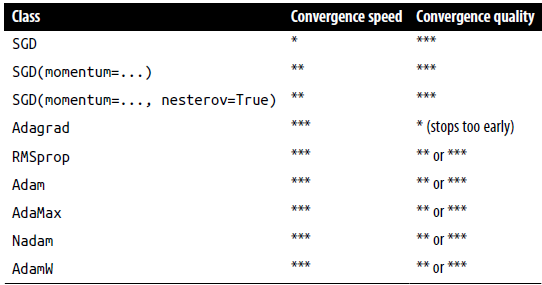
    <br>

* **Training Sparse Models**:
    * All the optimization algorithms above produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.
    * One way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to zero). However, this will typically not lead to a very sparse model, and it may degrade the model’s performance.
    * A better option is to apply strong ℓ1 regularization during training, as it pushes the optimizer to zero out as many weights as it can.
    * If these techniques remain insufficient, check out the TensorFlow Model Optimization Toolkit (TF-MOT), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

In [53]:
optimizer = tf.keras.optimizers.experimental.AdamW(
    weight_decay = 0.00005,
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999
)

In [54]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
